# Fingerprint Recognition - Rede Neural Siamesa utilizando AlexNet como backbone
Projeto Disciplina MC855/853 - 1s2022

O objetivo é o de realizar a construção de uma rede neural convolucional para a identificação de *fingerprints*. Para isso, utilizamos o método de treinamento conhecido como aprendizado contrastivo, em que a função de perda é uma distância entre duas imagens de entrada.



## Dataset
Os dados enviados para o modelo são pares de comparações de imagens de fingerprint. Utilizamos para treinamento e validação o subconjunto DB1_A, e para teste DB1_B. Ambos fazem parte do FVC2006 *fingerprint* database (http://bias.csr.unibo.it/fvc2006). O arquivo de comparações de treino e validação será dividido no arquivo comparisons_A.txt e para o teste new_comparisons_B.txt.

In [ ]:
# Loading the datasets folder from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
main_path = "/content/drive/MyDrive/MC853/fingerprint_recognition/"
dataset_path = main_path+"datasets.zip" # preencha com o path do seu arquivo .zip de dataset

zip_ref = zipfile.ZipFile(dataset_path, 'r') # Upload the datasets folder in your drive
zip_ref.extractall() #Extracts the files into the /tmp folder
zip_ref.close()

## Importando e instalando dependências

In [ ]:
# !pip uninstall imgaug
!pip install imgaug==0.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 948 kB 30.3 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [ ]:
# colab environment doesnt have torch_snippets
!pip install -q torch_snippets

     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 58 kB 6.9 MB/s 
     |████████████████████████████████| 235 kB 66.5 MB/s 
     |████████████████████████████████| 51 kB 7.6 MB/s 


In [ ]:
from torch_snippets import *
import torch
from torchvision    import transforms, models

device = 'cuda' if torch.cuda.is_available() else 'cpu' # colab offers limited gpu acess
print(device)

cuda


### Parte I - Construindo a classe de dataset

Conforme discutido ao longo das aulas, na estrutura do PyTorch, além do modelo em si, uma classe obrigatória é uma de Dataset. Essa é uma classe especificada pelo usuário, mas que herda da classe Dataset do Pytorch. Devemos redefinir 3 métodos dessa classe:



1.   *init*, em que declaramos as variáveis de caminho para a pasta de imagens, caminho para o arquivo de comparações e a função de transformação dos dados (*data augmentation*)
2.   *getitem*. Esse é o método chamado pelo objeto de Dataloader, que será explorado mais a frente. Aqui precisamos retornar **tensores** que representam as imagens de entrada, assim como o **label** (verdadeiro ou falso)
3. len, o qual retorna o tamanho do dataset

**Ao mudar o conjunto de dados de entrada, é fundamental checar se é preciso ou não fazer alterações nessa classe de dataset, já que muda-se, também, o arquivo de comparação de entrada (observe que existe uma manipulação de string no *getitem* especifica para o formato do arquivo *comparisons_A.txt*. O mesmo acontece quando modifica-se a função de loss para usar a triplet_loss, por exemplo.** 



In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, image_folder, imagenames_file, transform=None):
        self.image_folder    = image_folder
        self.imagenames_file = imagenames_file
        self.nitems          = 0
        self.transform       = transform
        self.nGenuino = 0
        self.nImpostor = 0

        f     = open(self.imagenames_file,"r")
        self.pairs = []
        for line in f:
            pair = line.strip().split(" ")
            self.pairs.append(pair)

            if pair[0].split("_")[0] == pair[1].split("_")[0]:
                self.nGenuino += 1
            else:
                self.nImpostor += 1

        self.nitems = len(self.pairs)

    def __getitem__(self, ix):
        image1      = self.pairs[ix][0]
        image2      = self.pairs[ix][1]
        
        person1 = image1.split("_")[0] # 001_01.png -> 001
        person2 = image2.split("_")[0] # 002_01.png -> 002
        
        if (person1 == person2):
            truelabel = 0
        else:
            truelabel = 1
        
        image1 = read("{}/{}".format(self.image_folder,image1))
        image2 = read("{}/{}".format(self.image_folder,image2))
        image1 = np.expand_dims(image1,2)
        image2 = np.expand_dims(image2,2)
        
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2, np.array([truelabel])
    def __len__(self):
        return self.nitems

    def getStats(self):        
        N = self.nGenuino + self.nImpostor
        print('Number of Images:', self.nitems)
        print('{}% da classe Genuína\n{}% da Classe Impostora'.format(round(100* self.nGenuino/N,2), round(100 * self.nImpostor/N),2))

Após a definição da classe de dataset, definimos os possíveis objetos de transformação. O *prep* realiza uma preparação inicial nas imagens de modo a padronizar o shape de entrada. O *aug*, além de fazer isso, aplica uma técnica conhecida como *data augmentation*, que serve para evitar o *overfitting*, mas pode aumentar bastante o esforço computacional para treinamento.

Utilize apenas *prep* para conjuntos de validação e de teste. Tanto *prep* quanto *aug* pode ser utilizado para o conjunto de treino

In [ ]:
from torchvision.transforms.transforms import ToPILImage
# Regular preprocessing transformation. After being resized, 
# it is converted into a tensor for normalization.

prepAlexNet = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) ),
])

Em seguida realizamos uma separação dos arquivos de treino e de validação. Basicamente estamos quebrando o arquivo txt de comparações em uma parte de treino e uma parte de validação, ao mesmo tempo que fazemos um *shuffle* nas linhas. 

Um possível experimento é o de mudar o percentual de dados utilizado para treino e para validação. Você pode modificar isso na célula abaixo.

In [ ]:
import random
with open("/content/datasets/comparisons_A.txt", 'r') as fp:
    data = [(random.random(), line) for line in fp]
    dataset_size = len(data)
    train_perc = 0.70
    valid_perc = 0.30
    num_train_samples = int(dataset_size*train_perc)
    num_valid_samples = int(dataset_size*valid_perc)
data.sort()

with open("train_comparisons.txt", 'w') as train:
  for _, line in data[:num_train_samples]:
    train.write(line)

with open("valid_comparisons.txt", 'w') as valid:
  for _, line in data[:num_valid_samples]:
    valid.write(line)

Vamos demonstrar a utilização da classe dataset e visualizar alguns pares de imagem de treinamento.

In [ ]:
image_folder = "/content/datasets/DB1_A" # folder with images of a dataset
train_imagenames_file = "/content/train_comparisons.txt" # csv file with image comparisons for training
valid_imagenames_file = "/content/valid_comparisons.txt" # csv file with image comparisons for validation

# criação do objeto da classe dataset
dataset    = SiameseNetworkDataset(image_folder=image_folder, imagenames_file = train_imagenames_file, transform=prepAlexNet)
dataset.getStats()

Number of Images: 13279
48.44% da classe Genuína
52% da Classe impostora


Number of images: 13279
Images are 100x100x1


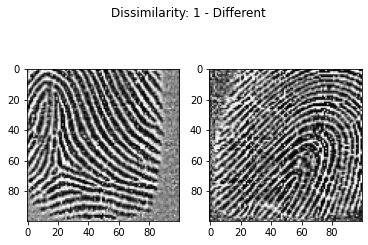

In [ ]:
print("Number of images: {}".format(len(dataset)))

# obtendo uma amostra aleatória do conjunto de dados
sample = random.randint(0, len(dataset))
image1, image2, label = dataset[sample]

# Visualizando as duas imagens de entrada, bem como o label
nchannels = image1.shape[0]
height    = image1.shape[1]
width     = image1.shape[2]

print("Images are {}x{}x{}".format(width,height,nchannels))

image1 = image1.squeeze()
image2 = image2.squeeze()

# Plotting images
fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax[0].imshow(image1, cmap='gray')
ax[1].imshow(image2, cmap='gray')
dissimilarity_text = 'Different' if label[0] else 'Equal'
plt.suptitle('Dissimilarity: {} - {}'.format(label[0], dissimilarity_text))
plt.subplots_adjust(hspace=0.5)
plt.show()


Essa é uma demonstração básica de como utilizar a classe Dataset. Sinta-se livre para realizar diferentes experimentos nesta seção. A construção do Dataset é tão impactante quanto o modelo em si em tarefas de *Deep Learning*.

## Parte II - Construindo a arquitetura da rede

In [ ]:
class SiameseNetworkAlexNetBackbone(nn.Module):
    def __init__(self):
        super(SiameseNetworkAlexNetBackbone, self).__init__()
        self.features = nn.Sequential(models.alexnet(pretrained=True))

        for param in self.features.parameters():
          param.requires_grad = False
      
        self.dimensionality_reductor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000, 512), nn.ReLU(inplace = True),
            nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 64)
        )


    def forward(self, input1, input2):
        output1 = self.features(input1)
        output1 = self.dimensionality_reductor(output1)
        output2 = self.features(input2)
        output2 = self.dimensionality_reductor(output2)

        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2)/2 +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))/2
        
        prediction = (euclidean_distance > contrastive_thres).float() #True for same and False for Different Classes
        is_corrected = (prediction == label).float()
        # acc = is_corrected.mean()
        acc = balanced_accuracy(label, prediction)
        return loss_contrastive, acc, is_corrected, euclidean_distance

def balanced_accuracy(true_label, pred_label):
    # pegando o total de cada classe
    FP_TN = true_label[(true_label == 0)].shape[0]
    TP_FN = true_label[(true_label == 1)].shape[0]

    # calculando quantos acertos tivemos de cada classe
    pred_label_correct = pred_label[pred_label == true_label]
    TN = pred_label_correct[(pred_label_correct == 0)].shape[0]
    TP = pred_label_correct[(pred_label_correct == 1)].shape[0]

    if (FP_TN > 0) and (TP_FN > 0):
        # se tenho as duas classes, calculo a acc balanceada
        balanced_acc = 1/2 * (TN/FP_TN + TP/TP_FN)
    elif (FP_TN > 0):
        balanced_acc = TN/FP_TN
    else:
        balanced_acc = TP/TP_FN

    return torch.tensor(balanced_acc, device=device)

def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc, _, _ =     criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

def valid_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]

    model.eval() # put the model in evaluation mode
    codesA, codesB = model(imgsA, imgsB) # predict the output for the batch
    loss, acc, _, _  = criterion(codesA, codesB, labels) # compute loss, both inputs must have the same sizes
    model.train()
    
    return loss.item(), acc.item()


## Parte III - Treino da rede

É importante iniciar esta seção destacando a necessidade de utilização do objeto do PyTorch chamado de DataLoader, que recebe como entrada um objeto da classe Dataset. Esse objeto realiza o agrupamento dos dados em *batches*, o que impacta bastante o processo de treinamento. A função *GetBatches* abaixo ilustra a utilização do DataLoader.

Iniciamos o script de treino definindo os objetos de DataLoader de treino e de validação.

In [ ]:
batchsize = 32

def GetBatches(image_folder, image_names, batchsize, transformation):
    datatensor = SiameseNetworkDataset(image_folder, image_names, transformation) 
    dataloader = DataLoader(datatensor, batch_size=batchsize, shuffle=True)
    return(dataloader)

trainload = GetBatches(image_folder, train_imagenames_file, batchsize, prepAlexNet)  # descomentar essa parte se for usar o backbone da VGG
validload = GetBatches(image_folder, valid_imagenames_file, batchsize, prepAlexNet)

print("Quantidade de batches de treino: ", len(trainload))
print("Quantidade de batches de validação: ", len(validload))

Quantidade de batches de treino:  415
Quantidade de batches de validação:  178


In [ ]:
inspect(next(iter(trainload))) # inspect a couple of items in the batches

list of 3 items
	Tensor	Shape: torch.Size([32, 3, 256, 256])	Min: 0.000	Max: 1.000	Mean: 0.491	dtype: torch.float32 @ cpu
	Tensor	Shape: torch.Size([32, 3, 256, 256])	Min: 0.000	Max: 1.000	Mean: 0.493	dtype: torch.float32 @ cpu
	Tensor	Shape: torch.Size([32, 1])	Min: 0.000	Max: 1.000	Mean: 0.531	dtype: torch.int64 @ cpu


Em seguida instanciamos os objetos do modelo, do *criterion* (loss) e do otimizador. O script de treino é dado logo abaixo.

**Esse é o momento mais necessário para a utilização da GPU**.

In [ ]:
model      = SiameseNetworkAlexNetBackbone().to(device)

criterion  = ContrastiveLoss()
optimizer  = optim.Adam(model.parameters(),lr = 0.001, weight_decay=0.01)
nepochs   = 10 # default training value was 200, but requires a lot of time

contrastive_thres = 1.1
best_model_path = main_path+f'models/best_model_exp2.pth'

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
log     = Report(nepochs)
patience = 0
stop = False
for epoch in range(nepochs):
    N = len(trainload)
    for i, data in enumerate(trainload):
        batch_loss, batch_acc = train_batch(model, data, optimizer, criterion)

        if i%100 == 0:

            valid_loss = 0
            valid_acc = 0
            with torch.no_grad():
                for j, data in enumerate(validload):
                    valid_batch_loss, valid_batch_acc = valid_batch(model, data, criterion)
                    # variavel acumuladora para calcular a média da loss dos batches de validação no modelo atual
                    valid_loss += valid_batch_loss
                    valid_acc += valid_batch_acc

                valid_loss = valid_loss / len(validload)
                valid_acc = valid_acc / len(validload)

                loss_increased = False
                if i == 0:
                    last_val_loss = valid_loss
                else:
                    # se a loss aumentar, eu paro o treinamento
                    if valid_loss > (last_val_loss + 0.01):
                        print('\npiorou')
                        patience += 1
                        if patience > 3:
                            last_val_loss = valid_loss
                            loss_increased = True
                            break
                    else:
                        print('\nmelhorando...')
                        patience = 0
                        
            log.record(epoch+(1+i)/N, trn_loss=batch_loss, trn_acc=batch_acc, val_loss=valid_loss, val_acc=valid_acc, end='\r')
            
    if loss_increased:
        break

log.plot_epochs()       

EPOCH: 0.002	trn_loss: 0.347	trn_acc: 0.583	val_loss: 0.260	val_acc: 0.729	(28.92s - 119989.75s remaining)
melhorando...
EPOCH: 0.243	trn_loss: 0.261	trn_acc: 0.692	val_loss: 0.231	val_acc: 0.768	(62.32s - 2498.55s remaining)
melhorando...
EPOCH: 0.484	trn_loss: 0.264	trn_acc: 0.677	val_loss: 0.237	val_acc: 0.770	(96.22s - 1890.43s remaining)
melhorando...
EPOCH: 0.725	trn_loss: 0.301	trn_acc: 0.688	val_loss: 0.214	val_acc: 0.796	(129.21s - 1652.27s remaining)
melhorando...
EPOCH: 1.002	trn_loss: 0.180	trn_acc: 0.869	val_loss: 0.219	val_acc: 0.782	(185.91s - 1668.70s remaining)
melhorando...
EPOCH: 1.243	trn_loss: 0.285	trn_acc: 0.663	val_loss: 0.214	val_acc: 0.790	(218.96s - 1542.09s remaining)
melhorando...
EPOCH: 1.484	trn_loss: 0.216	trn_acc: 0.806	val_loss: 0.209	val_acc: 0.803	(252.23s - 1447.04s remaining)
melhorando...
EPOCH: 1.725	trn_loss: 0.329	trn_acc: 0.648	val_loss: 0.200	val_acc: 0.800	(285.82s - 1370.84s remaining)
melhorando...
EPOCH: 2.002	trn_loss: 0.261	trn_acc: 0.6

KeyboardInterrupt: ignored

Não esqueça de salvar os modelos após o treinamento! 

In [ ]:
torch.save(model.state_dict(), best_model_path)

## Parte IV -  Avaliação do modelo treinado

Após o treino do modelo, devemos visualizar como ele é capaz de generalizar para novos dados. Uma boa ideia é a de testar em bases de dados diferentes, por exemplo, se você utilizou a DB1_A para treinamento e validação, pode utilizar a DB1_B para teste.

Caso você tenha treinado um modelo em uma sessão anterior, é uma boa ideia colocá-lo no drive e simplesmente definir o seu path na célula abaixo.

In [ ]:
# Se já possui um modelo treinado, carregue os pesos
model.load_state_dict(torch.load(best_model_path))
model.eval()

Avaliando os dados de validação para ter métricas e definir threshold.

In [ ]:
import seaborn as sns
def evaluate(model, dataloader, ngenuino, nimpostor, plot=True):
    #put model in evaluation mode
    model.eval()


    Acc = []
    Loss = []
    same_distance = []
    different_distance = []
    acertos_same = 0
    acertos_diff = 0

    #process all batches
    for ix, data in enumerate(dataloader):
        imgA, imgB, label = [t.to(device) for t in data]
        codeA, codeB       = model(imgA, imgB)
        with torch.no_grad():            
            loss, _, is_corrected, euclidean_distance            = criterion(codeA, codeB, label)
            euclidean_distance = euclidean_distance.item()
            is_corrected = is_corrected.item()

            if label == 1:
                if is_corrected == 1:
                    acertos_diff += 1

                different_distance.append(euclidean_distance)
            else:
                if is_corrected == 1:
                    acertos_same += 1
                
                same_distance.append(euclidean_distance)
            Loss.append(loss.detach().cpu().numpy())
    
    balanced_acc = 1/2 * (acertos_same/ngenuino + acertos_diff/nimpostor)
    overall_acc = (acertos_same + acertos_diff)/(ngenuino + nimpostor)
    same_distance = np.array(same_distance)
    different_distance = np.array(different_distance)

    print('Acurácia BALANCEADA: {:.6f}'.format(balanced_acc))
    print('Acurácia NORMAL: {:.6f}'.format(overall_acc))
    print('Loss: {:.6f}'.format(np.mean(Loss)))
    print('Média Impostor: ', different_distance.mean())
    print('Erro Impostor: ',different_distance.std())
    print('Média Genuína: ',same_distance.mean())
    print('Erro Genuína: ', same_distance.std())

    if plot:
        fig, ax = plt.subplots(figsize = (10,5))
        ax.set_title('Histograma de distâncias para as duas classes', fontsize = 20, fontweight = 'bold')
        ax.set_xlabel('Distância Euclidiana', fontsize = 16, fontweight = 'bold')
        ax.set_ylabel('Densidade', fontsize = 16, fontweight = 'bold')
        ax.hist(different_distance,bins = 50, alpha = 0.7, label = 'different')
        ax.hist(same_distance, bins = 50, alpha = 0.7, label = 'same')
        ax.tick_params(labelsize = 16, axis = 'both')
        ax.legend()
        ax.grid(True)
        plt.plot()


Number of Images: 5691
48.01% da classe Genuína
52% da Classe impostora
Acurácia BALANCEADA: 0.814810
Acurácia NORMAL: 0.814971
Loss: 0.196289
Média Impostor:  1.6351780153511344
Erro Impostor:  0.5664301373773944
Média Genuína:  0.7540400767832515
Erro Genuína:  0.44268884901897554


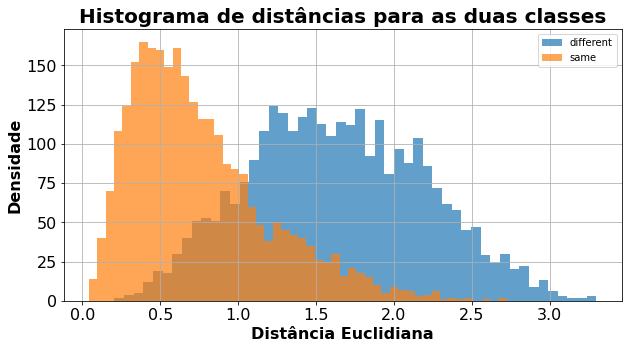

In [ ]:
datatensor = SiameseNetworkDataset(image_folder, valid_imagenames_file, prepAlexNet) 
datatensor.getStats()

validload2 = GetBatches(image_folder, valid_imagenames_file, 1, prepAlexNet)
evaluate(model, validload2, datatensor.nGenuino, datatensor.nImpostor)

Avaliação nos dados de Teste (feito por último)

Novamente definimos os caminhos para as pastas de imagens e arquivo de comparação do novo conjunto de dados. Utilize uma base de dados diferente da que foi utilizada para o treino. Por exemplo, aqui utilizamos a DB1_B.

In [ ]:
test_image_folder = "/content/datasets/DB1_B" # folder with images of a dataset
test_imagenames_file = "/content/datasets/new_comparisons_B.txt" # csv file with image comparisons for test
datatensor = SiameseNetworkDataset(test_image_folder, test_imagenames_file, prepAlexNet) 
datatensor.getStats()

# EVALUATION REQUIRES BATCH SIZE = 1
testload = GetBatches(test_image_folder, test_imagenames_file, 1, prepAlexNet)

Number of Images: 4800
30.0% da classe Genuína
70% da Classe impostora


Acurácia BALANCEADA: 0.505208
Acurácia NORMAL: 0.307292
Loss: 0.649585
Média Impostor:  0.6672482535597823
Erro Impostor:  0.1725732456123784
Média Genuína:  0.4351486376642899
Erro Genuína:  0.20915040122101788


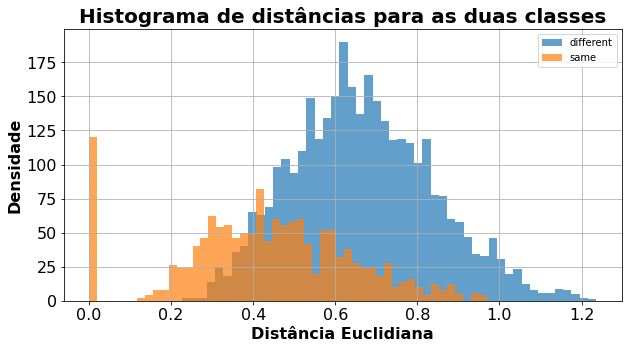

In [ ]:
evaluate(model, testload, datatensor.nGenuino, datatensor.nImpostor)

## Parte V - Deploy

In [ ]:
# model.eval()
# do_comparison = 'y'

# image_folder = '/content/datasets/DB1_A'
# imagenames_file = '/content/datasets/comparisons_A.txt'

# dataset       = SiameseNetworkDataset(image_folder=image_folder, imagenames_file = imagenames_file, transform=prep)

# dataloader    = DataLoader(dataset,batch_size=1,shuffle=True)

# while(do_comparison=='y'):
#     dataiter                  = iter(dataloader)
#     image1, image2, truelabel = [t.to(device) for t in next(dataiter)]
#     concatenated              = torch.cat((image1*0.5+0.5, image2*0.5+0.5),0)

#     output1,output2           = model(image1,image2)
#     euclidean_distance        = F.pairwise_distance(output1, output2)
#     if (euclidean_distance.item() <= contrastive_thres):
#         if (truelabel != 0):
#             output = 'Same Person, which is an error.'
#         else:
#             output = 'Same Person, which is correct.'
#     else:
#         if (truelabel == 0):
#             output = 'Different, which is an error.'
#         else:
#             output = 'Different, which is correct.'
    
#     show(torchvision.utils.make_grid(concatenated),
#          title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
#     plt.show()
#     do_comparison = input("Type y to continue: ")
